In [42]:
# Import necessary libraries
import pandas as pd         
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import warnings
# Suppress warnings
warnings.filterwarnings('ignore')
import cv2
from google.colab.patches import cv2_imshow

**Using google Colab**

In [43]:
from google.colab import drive
# drive.mount('/gdrive')
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
images = np.load('/content/drive/My Drive/images.npy')

In [45]:
labels = pd.read_csv('/content/drive/My Drive/Labels.csv')

In [46]:
# Image shape
images.shape
#  128X128 dimentioned, colored images

(4750, 128, 128, 3)

In [48]:
# Printing labels
print(labels['Label'].unique())
print(labels['Label'].nunique())

['Small-flowered Cranesbill' 'Fat Hen' 'Shepherds Purse' 'Common wheat'
 'Common Chickweed' 'Charlock' 'Cleavers' 'Scentless Mayweed' 'Sugar beet'
 'Maize' 'Black-grass' 'Loose Silky-bent']
12


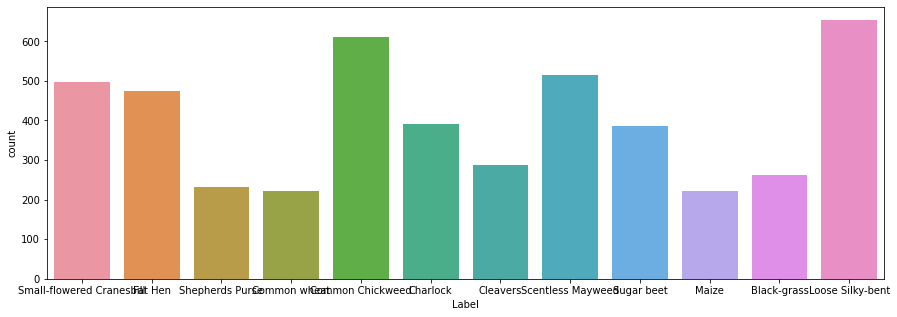

In [49]:
# Labels distribution
import seaborn as sns
fig, ax = plt.subplots(figsize = (15,5))
sns.countplot(x='Label', data=labels)

Label 
 Label Id: Small-flowered Cranesbill


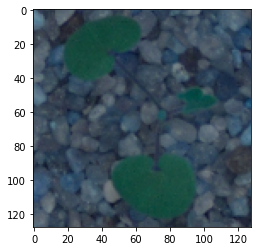

In [50]:
# visualize an example of data
i = 6
image = images[i]
label = labels['Label'][i]
print(f'Label \n Label Id: {label}')
plt.imshow(image);

**Images preprocessing**

In [52]:
# GaussianBlur and Masking images
import cv2
imagesblur=images

for i in range(len(images)):
  temp= cv2.GaussianBlur(images[i], (5, 5), 0)
  temp= cv2.cvtColor(temp, cv2.COLOR_BGR2HSV)


  lower_hsv = np.array([25,40,50])
  upper_hsv = np.array([75,255,255])
  mask = cv2.inRange(temp, lower_hsv, upper_hsv)

  imagesblur[i] = cv2.bitwise_and(images[i],images[i], mask= mask)
 
imagesblur.shape

(4750, 128, 128, 3)

blurr image 
 Label Id: Small-flowered Cranesbill


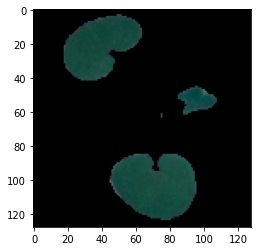

In [53]:
# visualize modified image
i = 6
image = imagesblur[i]
label = labels['Label'][i]
#print(' Label \n Label Id: {} \n Name: {}'.format(label, label_dict[label]))
print(f'blurr image \n Label Id: {label}')
plt.imshow(image);

In [54]:
# Images normalization
imagesblur = imagesblur.astype('float32')
imagesblur /= 255.0

**Making data compatable**

In [55]:
# Convert labels to binary codes
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [56]:
labeled=le.fit_transform(labels)

In [58]:
from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
labeledbinary = enc.fit_transform(labeled)

In [59]:
# Splitting data into 3 (Train, Vaildation and Test)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(imagesblur, labeledbinary, test_size=0.3, random_state = 123)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state = 123)

In [60]:
y_train[0] # Label for first entry in training data

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [61]:
y_val[0] # Label for first entry in validation data

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0])

In [62]:
print('Train Set',X_train.shape)
print('Validation Set',X_val.shape)
print('Test Set',X_test.shape)
# The shape of the data os compatable with KERAS

Train Set (3325, 128, 128, 3)
Validation Set (712, 128, 128, 3)
Test Set (713, 128, 128, 3)


In [63]:
# Importing needed libraries from tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import BatchNormalization, GlobalMaxPooling2D
from tensorflow.keras import optimizers

In [64]:
# Initialising the CNN classifier

classifier = Sequential()

# Add a Convolution layer with 128 kernels of 5X5 shape with activation function ReLU
classifier.add(Conv2D(128, (5, 5), input_shape = (128, 128, 3), activation = 'relu'))
classifier.add(BatchNormalization())

# Add a Max Pooling layer of size 2X2
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Add another Convolution layer
classifier.add(Conv2D(64, (3, 3), activation = 'relu'))
classifier.add(BatchNormalization())
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Add another Convolution layer
classifier.add(Conv2D(64, (3, 3), activation = 'relu'))
classifier.add(BatchNormalization())
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Add another Convolution layer
classifier.add(Conv2D(64, (3, 3), activation = 'relu'))
classifier.add(BatchNormalization())
classifier.add(MaxPooling2D(pool_size = (2, 2)))


classifier.add(GlobalMaxPooling2D())

classifier.add(Flatten())

# Adding a fully connected layer with 512 neurons
classifier.add(Dense(units = 512, activation = 'relu'))

# Adding a fully connected layer with 128 neurons
classifier.add(Dense(units = 128, activation = 'relu'))

# The final output layer with 12 neurons to predict the categorical classifcation
classifier.add(Dense(units = 12, activation = 'softmax'))
classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 124, 124, 128)     9728      
_________________________________________________________________
batch_normalization (BatchNo (None, 124, 124, 128)     512       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 64)        73792     
_________________________________________________________________
batch_normalization_1 (Batch (None, 60, 60, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        3

In [65]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

#Adding Model Checkpoint callback to the fit function is going to save the weights whenever val_loss achieves a new low value. 
#Hence saving the best weights occurred during training

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10)

model_checkpoint =  ModelCheckpoint('cifar_cnn_checkpoint_{epoch:02d}_loss{val_loss:.4f}.h5',
                                                           monitor='val_loss',
                                                           verbose=1,
                                                           save_best_only=True,
                                                           save_weights_only=True,
                                                           mode='auto',
                                                           period=1)

In [66]:
# Setting optimizer and loss function
opt = optimizers.Adam(lr = 0.001)
classifier.compile(optimizer=opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [67]:
history = classifier.fit(X_train, y_train, batch_size=15, epochs=25, validation_data=(X_val, y_val), verbose=2, callbacks=[early_stopping,model_checkpoint])

Epoch 1/25

Epoch 00001: val_loss improved from inf to 3.57383, saving model to cifar_cnn_checkpoint_01_loss3.5738.h5
222/222 - 11s - loss: 1.6770 - accuracy: 0.4280 - val_loss: 3.5738 - val_accuracy: 0.0590
Epoch 2/25

Epoch 00002: val_loss did not improve from 3.57383
222/222 - 10s - loss: 1.1062 - accuracy: 0.6211 - val_loss: 4.0699 - val_accuracy: 0.0843
Epoch 3/25

Epoch 00003: val_loss improved from 3.57383 to 0.93287, saving model to cifar_cnn_checkpoint_03_loss0.9329.h5
222/222 - 10s - loss: 0.8533 - accuracy: 0.7002 - val_loss: 0.9329 - val_accuracy: 0.6573
Epoch 4/25

Epoch 00004: val_loss did not improve from 0.93287
222/222 - 10s - loss: 0.7121 - accuracy: 0.7456 - val_loss: 1.3143 - val_accuracy: 0.5702
Epoch 5/25

Epoch 00005: val_loss did not improve from 0.93287
222/222 - 10s - loss: 0.6013 - accuracy: 0.7886 - val_loss: 1.1707 - val_accuracy: 0.5927
Epoch 6/25

Epoch 00006: val_loss did not improve from 0.93287
222/222 - 10s - loss: 0.5022 - accuracy: 0.8226 - val_loss

**Model evaulation**

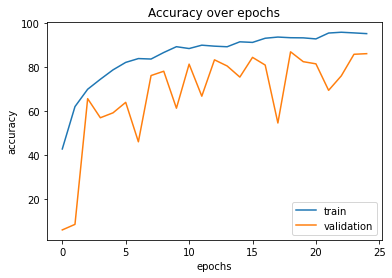

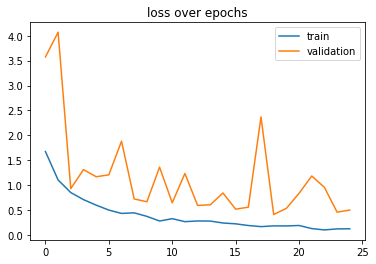

In [68]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

# Accuracy over epochs figure

plt.plot(np.array(history.history['accuracy']) * 100)
plt.plot(np.array(history.history['val_accuracy']) * 100)
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'validation'])
plt.title('Accuracy over epochs')
plt.show()


# loss over epochs figure
plt.title('loss over epochs')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'validation'])
plt.show()

In [69]:
scores = classifier.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

23/23 [==============================] - 1s 33ms/step - loss: 0.4350 - accuracy: 0.8583
Test loss: 0.43499335646629333
Test accuracy: 0.8583450317382812


In [92]:
from tensorflow.math import confusion_matrix
y_pred=classifier.predict_classes(X_test)
con_mat = confusion_matrix(labels=y_test, predictions=y_pred).numpy()
classes=[0,1,2,3,4,5,6,7,8,9,10,11]

In [93]:
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
 
con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes, 
                     columns = classes)

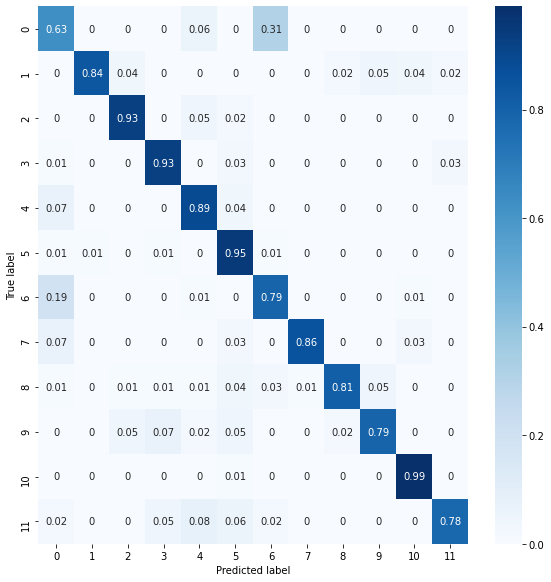

In [94]:
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

**visulaization of predications**

True label 6
Predicted label 6


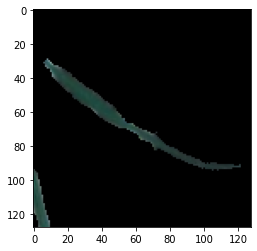

In [106]:
plt.imshow(X_test[2]);
print ('True label',y_test[2])
print ('Predicted label',y_pred[2])

True label 5
Predicted label 5


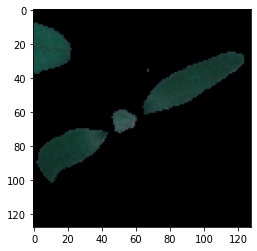

In [100]:
plt.imshow(X_test[3]);
print ('True label',y_test[3])
print ('Predicted label',y_pred[3])

True label 3
Predicted label 3


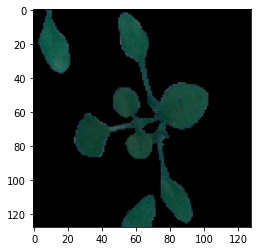

In [101]:
plt.imshow(X_test[33]);
print ('True label',y_test[33])
print ('Predicted label',y_pred[33])

True label 4
Predicted label 4


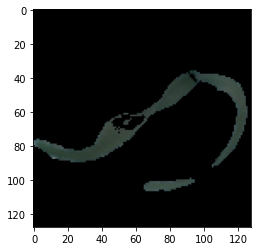

In [102]:
plt.imshow(X_test[36]);
print ('True label',y_test[36])
print ('Predicted label',y_pred[36])

True label 7
Predicted label 7


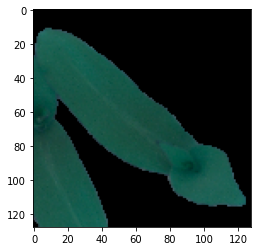

In [103]:
plt.imshow(X_test[59]);
print ('True label',y_test[59])
print ('Predicted label',y_pred[59])

**Remarks**

*   Model is fitting good with train accuracy up to 95% and test accuracy yo 95%
*   Confusion matrix is good too. but there is some crosslabeling between label 0 and 6

